In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [2]:
# # Set up the WebDriver
# driver_path = 'C:/Users/arshi/chromedriver-win64/chromedriver.exe'  # Your ChromeDriver path
# service = webdriver.chrome.service.Service(driver_path)
# driver = webdriver.Chrome(service=service)

#### Preparing the data

In [3]:
data = pd.read_csv('data/JAN_2025.csv')
data['Last'].replace('-',np.nan,inplace = True)
# data['Last'] = data['Last'].astype(float)
data.shape

(297, 11)

In [4]:
df = data.loc[:,['Month','Updated','Last']]
df

,Month,Updated,Last
0,JAN 2025\nCLF5,21:06:46 CT\n15 Oct 2024,69.82
1,JAN 2025\nCLF5,21:17:32 CT\n15 Oct 2024,69.82
2,JAN 2025\nCLF5,21:24:10 CT\n15 Oct 2024,69.82
3,JAN 2025\nCLF5,21:36:06 CT\n15 Oct 2024,69.77
4,JAN 2025\nCLF5,21:47:18 CT\n15 Oct 2024,69.81
...,...,...,...
292,JAN 2025\nCLF5,09:16:59 CT\n18 Oct 2024,68.33
293,JAN 2025\nCLF5,09:27:59 CT\n18 Oct 2024,68.09
294,JAN 2025\nCLF5,09:37:57 CT\n18 Oct 2024,68.21
295,JAN 2025\nCLF5,09:48:58 CT\n18 Oct 2024,68.34


### Every 10 minute data

In [5]:
# # df['Updated'] = pd.to_datetime(
# #     df['Updated'].str.replace(' CT', '').str.split('\n').str[1] + ' ' + df['Updated'].str.split('\n').str[0].str.split(' ').str[0],
# #     format='%d %b %Y %H:%M:%S'
# # )
# # df.set_index('Updated', inplace=True)
# # df.drop('Month', axis=1, inplace=True)


# df_10min = df.resample('10T').last()
# df_10min.reset_index(inplace=True)
# df_10min.rename(columns={'Updated': 'Time', 'Last': 'Closing Price'}, inplace=True)
# df_hourly['Closing Price'] = df_hourly['Closing Price'].astype(float)
# df_10min['Closing Price'] = df_10min['Closing Price'].interpolate(method='time')
# df_10min

In [6]:
# # Plot the resampled hourly data
# plt.figure(figsize=(12, 6))
# plt.plot(df_10min['Time'], df_10min['Closing Price'], marker='o', linestyle='-', color='b')
# plt.title('Hourly Closing Price Over Time')
# plt.xlabel('Time')
# plt.ylabel('Closing Price')
# plt.grid(True)
# plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
# plt.tight_layout()

# # Show the plot
# plt.show()

In [7]:
# df_10min.iloc[-255:-200]

### Hourly Data

In [8]:
df['Updated'] = pd.to_datetime(
    df['Updated'].str.replace(' CT', '').str.split('\n').str[1] + ' ' + df['Updated'].str.split('\n').str[0].str.split(' ').str[0],
    format='%d %b %Y %H:%M:%S'
)
df.set_index('Updated', inplace=True)
df.drop('Month', axis=1, inplace=True)

df_hourly = df.resample('1H').last()
# Reset index and rename columns
df_hourly.reset_index(inplace=True)
df_hourly.rename(columns={'Updated': 'Time', 'Last': 'Closing Price'}, inplace=True)
# df_hourly['Closing Price'].replace('NaN', np.nan, inplace=True)
# df_hourly['Closing Price'] = df_hourly['Closing Price'].interpolate(method='time')
df_hourly['Closing Price'] = df_hourly['Closing Price'].astype(float)
# df_hourly.set_index('Time', inplace=True)
df_hourly['Closing Price'].fillna(method='ffill', inplace=True)


In [9]:
df_hourly.head()

,Time,Closing Price
0,2024-10-15 21:00:00,69.87
1,2024-10-15 22:00:00,69.86
2,2024-10-15 23:00:00,69.93
3,2024-10-16 00:00:00,69.86
4,2024-10-16 01:00:00,69.82


In [10]:
df_hourly.iloc[15:30]

,Time,Closing Price
15,2024-10-16 12:00:00,69.47
16,2024-10-16 13:00:00,69.41
17,2024-10-16 14:00:00,69.58
18,2024-10-16 15:00:00,69.71
19,2024-10-16 16:00:00,69.71
20,2024-10-16 17:00:00,69.69
21,2024-10-16 18:00:00,69.74
22,2024-10-16 19:00:00,69.90
23,2024-10-16 20:00:00,69.96
24,2024-10-16 21:00:00,69.71


In [11]:
df_hourly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Time           61 non-null     datetime64[ns]
 1   Closing Price  61 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.1 KB


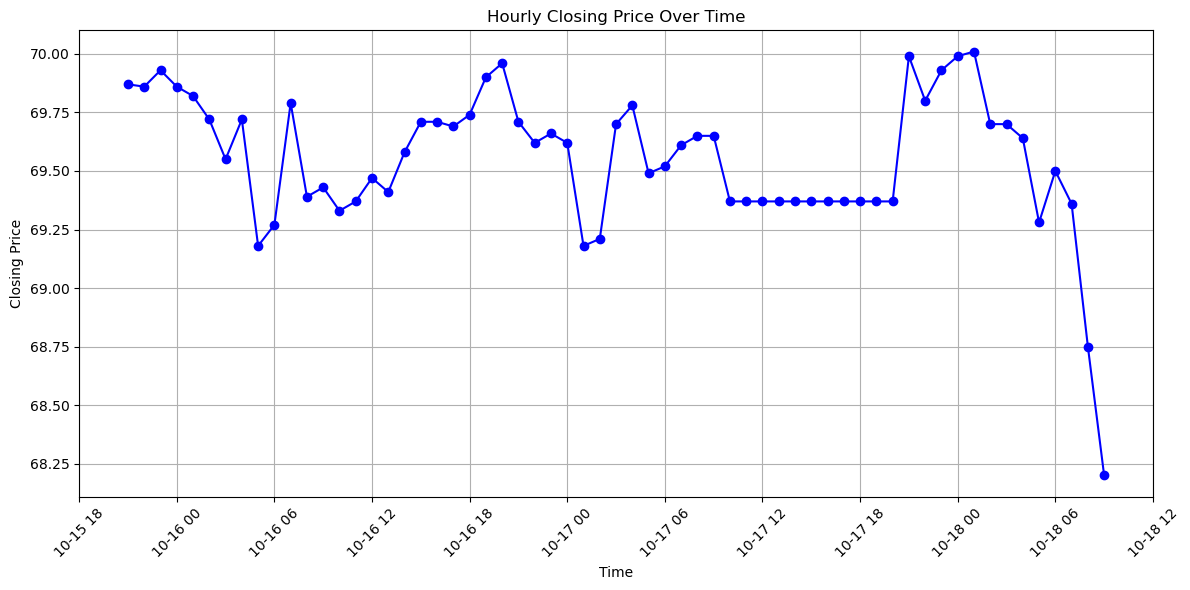

In [12]:
# Plot the resampled hourly data
plt.figure(figsize=(12, 6))
plt.plot(df_hourly['Time'], df_hourly['Closing Price'], marker='o', linestyle='-', color='b')
plt.title('Hourly Closing Price Over Time')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()

### Checking for stationarity

In [13]:
result = adfuller(df_hourly["Closing Price"])
stationarity_interpretation = "Stationary" if result[1] < 0.05 else "Non-Stationary"

print(f"ADF Statistic after differencing: {result[0]}")
print(f"p-value after differencing: {result[1]}")
print(f"Interpretation: The series is {stationarity_interpretation}.")

ADF Statistic after differencing: -1.418887356060595
p-value after differencing: 0.5731885395337292
Interpretation: The series is Non-Stationary.


#### Train Test Split

In [14]:
# Split the data into training and testing sets
train_size = int(len(df_hourly) * 0.8)
train, test = df_hourly['Closing Price'].iloc[:train_size], df_hourly['Closing Price'].iloc[train_size:]
print(train.shape, test.shape)

(48,) (13,)


#### Model building

In [18]:
model1 = ARIMA(train, order=(1, 2, 2))   # p,d,q
model_fit = model1.fit()

c:\Users\arshi\anaconda3\envs\price_forecast\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [19]:
predictions = model_fit.forecast(steps=len(test))
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse:.2f}')

Root Mean Squared Error: 0.54


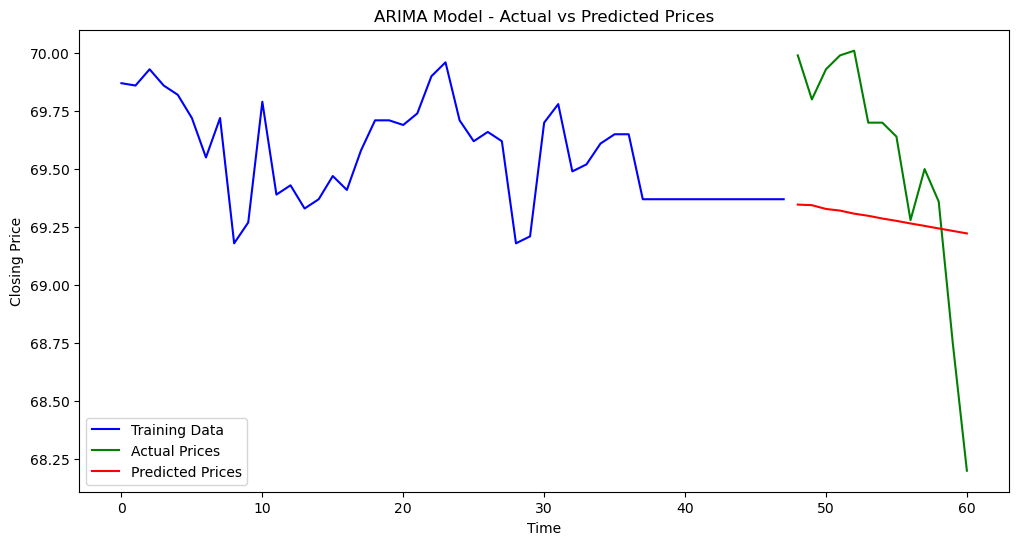

In [20]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data',color='blue')
plt.plot(test.index, test, label='Actual Prices',color='green')
plt.plot(test.index, predictions, label='Predicted Prices', color='red')
plt.title('ARIMA Model - Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()
plt.show()